<p><img alt="Colaboratory logo" height="140px" src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" align="left" hspace="10px" vspace="0px"></p>

# **Diplomado de Análisis de datos y Machine Learning en Python**


El presente diplomado hace parte del centro de Big Data de la facultad de ciencias exactas y naturales (FCEN) de la Universidad de Antioquia.

## **Sesión 15**

## **Contenido**

- <a href="#pip"> Pipelines</a><br>
- <a href="#val"> Validación cruzada</a><br>
- <a href="#pol"> Regresión polinomial</a><br>



<p><a name="pip"></a></p>

# **Pipelines**

Hemos visto cómo la aplicación de un sistema de ML requiere de diferentes etapas: preprocesado de los datos, construcción del modelo y su posterior evaluación. Vimos también cómo esta etapa de preprocesado afecta directamente los resultados que obtenemos del modelo final.

Vamos a ver cómo podemos simplificar los diferentes pasos en el preprocesamiento, así como la construcción del modelo, mediante el uso de los *pipelines*.



<p><img alt="Colaboratory logo" height="340px" src="https://i.imgur.com/Q5C8NGb.png" align="left" hspace="10px" vspace="0px"></p>

Un *Pipeline* es un objeto que nos permite encadenar varios pasos del workflow de ML secuencialmente. Específicamente, un Pipeline agrupa los pasos de preprocesamiento y modelado como si tratara de un solo paso, de manera que podamos automatizar todo el proceso manteniendo el código de preprocesamiento y de modelado de una forma muy organizada.

Las dos principales ventajas de trabajar con pipelines son las siguientes:

* Normalmente necesitaremos realizar un seguimiento como tal de los datos de entrenamiento y prueba en cada uno de los pasos de preprocesado, modelado y evaluación, lo que supone una tarea muy complicada desde el punto de vista de la implementación. Con los *pipelines* no necesitaremos de este seguimiento y tendremos un código mucho más simple y limpio.

* Con los pipelines, vamos a poder evaluar todo el proceso, que incluye las etapas de preprocemiento y de construcción del modelo, como un todo. Más que evaluar solo el modelo final, como lo veníamos haciendo.

Tal vez esta última sea la principal ventaja que tendremos a la hora de trabajar con pipelines.

Volvamos al problema en el que hemos estado trabajando:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/tomasate/Diplomado_ML/main/datasets/data/nivel_1/Data/FuelConsumption.csv").drop(columns="MODELYEAR")
df.head()

,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [4]:
X = df.drop(columns = ['CO2EMISSIONS'])

y = df[['CO2EMISSIONS']]

El *pipeline* aplica secuencialmente una lista de transformadores y un estimador final. Los pasos intermedios del *pipeline* deben ser 'transformaciones', es decir, deben implementar los métodos `fit` y `transform`. El estimador final solo necesita implementar el método `fit`.

In [5]:
from sklearn.pipeline import Pipeline
Pipeline?

Variables numéricas:

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer()
scale = StandardScaler()

num_transform = Pipeline([("num_imp", num_imputer),
                          ('scale', scale)])

num_transform

Variables categóricas:

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_imputer = SimpleImputer(strategy="most_frequent")
ohe = OneHotEncoder(sparse= False, drop= 'first')

cat_transform = Pipeline([('cat_imp', cat_imputer), 
                          ('ohe', ohe)])

cat_transform

Pipeline(memory=None,
         steps=[('cat_imp',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='most_frequent',
                               verbose=0)),
                ('ohe',
                 OneHotEncoder(categories='auto', drop='first',
                               dtype=<class 'numpy.float64'>,
                               handle_unknown='error', sparse=False))],
         verbose=False)

Alternativamente, podemos utilizar la clase ` make_pipeline`, la cual es un alias para `pipeline` en la que no tenemos que hacer explítico el nombre de la transformación:

In [ ]:
from sklearn.pipeline import make_pipeline

num_tra = make_pipeline(num_imputer, scale)
num_tra

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True))],
         verbose=False)

In [ ]:
cat_tra = make_pipeline(cat_imputer, ohe)
cat_tra

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='most_frequent',
                               verbose=0)),
                ('onehotencoder',
                 OneHotEncoder(categories='auto', drop='first',
                               dtype=<class 'numpy.float64'>,
                               handle_unknown='error', sparse=False))],
         verbose=False)

Ahora, vamos a querer aplicar estas transformaciones que hemos definido a nuestro conjunto de datos. 

En principio podríamos seleccionar las caracteristicas numéricas y categóricas y aplicar la transformación correspondiente a cada una de estas y al final combinar ambas características transformadas en un solo conjunto de datos. 

Sin embargo, este es el proceso que queremos evitar, recuerdomes que queremos tener todo el proceso automatizado, de manera que no nos tengamos que preocupar por este tipo de pasos. 

Lo que haremos, será utilizar un transformador de columnas `ColumnTransformer` (o `make_column_transformer`), de manera que construyamos un único objeto que realice estas tareas de preprocesamiento de una forma más simple y automática.

In [ ]:
df.dtypes

MAKE                         object
MODEL                        object
VEHICLECLASS                 object
ENGINESIZE                  float64
CYLINDERS                     int64
TRANSMISSION                 object
FUELTYPE                     object
FUELCONSUMPTION_CITY        float64
FUELCONSUMPTION_HWY         float64
FUELCONSUMPTION_COMB        float64
FUELCONSUMPTION_COMB_MPG      int64
CO2EMISSIONS                  int64
dtype: object

In [ ]:
from sklearn.compose import make_column_transformer

make_column_transformer?

Ahora que tenemos el proceso de transformación de los datos en este objeto, nos resta añadir el paso de construcción del modelo de manera que tengamos todo el proceso en un solo objeto. Para esto, de nuevo, utilizaremos un Pipeline

In [ ]:
num_cols = ['ENGINESIZE', 'FUELCONSUMPTION_CITY']
cat_cols = ['MAKE', 'CYLINDERS', 'VEHICLECLASS', 'TRANSMISSION', 'FUELTYPE']

preprocessor = make_column_transformer((num_transform, num_cols),
                                       (cat_transform, cat_cols))

preprocessor

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('pipeline-1',
                                 Pipeline(memory=None,
                                          steps=[('num_imp',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='mean',
                                                                verbose=0)),
                                                 ('scale',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                       

Una vez tenemos todo el proceso en este único objeto, podemos entrenar el modelo

In [ ]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()

model = make_pipeline(preprocessor, LR)
model

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('num_imp',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                   

Evaluemos el modelo

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('num_imp',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                   

In [ ]:
model.score(X_test,y_test)

0.9868248096273143

In [ ]:
df.head()

,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [ ]:
model['linearregression'].coef_.shape

(1, 85)

In [ ]:
model['linearregression'].intercept_

array([286.03765593])

<p><a name="val"></a></p>

# **Validación cruzada**

Hasta el momento lo que hemos hecho para la evaluación de los modelos supervisados es lo siguiente:

* Separar nuestro conjunto de datos en conjuntos de entrenamiento y prueba usando el método `train_test_split`.
* Entrenar un modelo a partir de los datos de entrenamiento mediante el método `fit`. 
* Evaluar con los datos de prueba usando el método `score`:

Recuerdomes que la razón por la que dividimos nuestros datos en los conjuntos de entrenamiento y prueba, es que estamos interesados en medir qué tan bien nuestro modelo se generaliza a nuevos datos. Es decir, no nos interesa saber qué tan bien se ajusta nuestro modelo a los datos de entrenamiento, sino más bien qué tan bien puede hacer predicciones para datos que no se observaron durante el proceso de entrenamiento.

Esta estrategia que hemos utilizado para la separación de los datos se conoce como *hold-out set*


![picture](https://www.researchgate.net/profile/Brian_Mwandau/publication/325870973/figure/fig6/AS:639531594285060@1529487622235/Train-Test-Data-Split.png)

Una desventaja de utilizar esta estrategia es que perdemos una porcion de nuestros datos para el entrenamiento del modelo. Esta no es la estrategia más óptima, y puede ademas causar problemas, especialmente si el conjunto de entrenamiento es pequeño.

Una forma de resolver este problema es usando lo que se conoce como *validación cruzada* (VC)

**K-fold Cross-validation**

La VC es un método estadístico para evaluar el rendimiento de generalización de un modelo, que es más estable y completo.

En la VC, se realiza una serie de ajustes donde cada subconjunto de los datos se utiliza tanto para el entrenamiento como para la prueba.

La versión más utilizada de la validación cruzada es la validación cruzada k-fold.

Por ejemplo, cuando utilizamos una VC de 5 folds, los datos se dividen en cinco partes de aproximadamente el mismo tamaño llamados folds, con los que se procede a entrenar una secuencia de modelos.





![picture](https://www.mathworks.com/matlabcentral/mlc-downloads/downloads/233459a6-523d-4cf7-91f3-ff539a1b58ce/f6c9980c-ed0d-4564-8289-e95c9274b48e/images/screenshot.png)



Al final, habremos obtenido cinco puntajes de validación para nuestro modelo Entonces, cuando utilizamos VC, cada instancia del conjunto de datos estará en el conjunto de entrenamiento exactamente una vez.

Es importante tener en cuenta que la validación cruzada no es una forma de construir un modelo que pueda aplicarse a nuevos datos. La validación cruzada no devuelve un modelo sino que crea múltiples modelos internamente con el propósito de evaluar qué tan bien se generalizará un modelo dado cuando se entrene en un conjunto de datos específico.

Veamos este proceso explícitamente con 2 folds:


In [ ]:
df.head()

,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [ ]:
X = df[['ENGINESIZE', 'FUELCONSUMPTION_CITY']]

X1, X2, y1, y2 = train_test_split(X, y, test_size = 0.5, random_state = 42)
LR.fit(X1,y1).score(X2,y2)

0.8612149544010091

In [ ]:
LR.fit(X2,y2).score(X1,y1)

0.8555962448041052

La VC la podemos implementar directamente desde Sklearn con la clase `cross_val_score`:

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(LR, X, y, cv = 2)

array([0.76682898, 0.87347252])

Note que obtenemos un resultado diferente al caso anterior. 

Hagamos una validación con 5 folds:

In [ ]:
cross_val_score(LR, X, y, cv = 5)

array([0.86939224, 0.76008033, 0.81394291, 0.88390099, 0.90541164])

Si observamos los cinco puntajes producidos por la validación cruzada, podemos concluir que existe una variación relativamente alta en la precisión entre los folds. Esto podría implicar que el modelo depende mucho de los folds particulares utilizados para el entrenamiento, pero también podría ser una consecuencia del pequeño tamaño del conjunto de datos.

Para definir explícitamente la forma en que separaremos los datos, podemos utilizar la clase `KFold`

In [ ]:
from sklearn.model_selection import KFold

cv = KFold(n_splits= 2, shuffle=True, random_state= 42)

cross_val_score(LR, X, y, cv = cv)

array([0.86121495, 0.85559624])

En resumen

* Con VC, utilizamos todos los datos para el entrenamiento, y no solo una porción de estos. cada instancia estará un uno de los folds, y cada fold a su vez será un conjunto de prueba una vez, por lo que estaremos usando nuestros datos de manera más efectiva. Así, el modelo necesita generalizar bien para todas las muestras del conjunto de datos de manera que todos los puntajes de validacion sean altos.

* Tener múltiples divisiones de los datos también nos proporciona información sobre cuán sensible es nuestro modelo a la selección del conjunto de datos de entrenamiento. En el ejemplo que hicimos, vimos precisiones entre 76% y 90%. Este es un rango bastante amplio y nos proporciona una idea sobre cómo podría funcionar el modelo en el peor de los casos y en el mejor de los casos cuando se aplica a nuevos datos.

* La principal desventaja de la validación cruzada es el aumento del costo computacional. Como ahora estamos entrenando k modelos en lugar de un solo modelo, la validación cruzada será aproximadamente k veces más lenta que hacer una sola división de los datos.

Ya hemos visto la receta básica para aplicar un modelo de ML supervisado:

* Escoger un tipo de modelo
* Escoger unos hiperparámetros
* Entrenar el modelo con unos datos de entrenamiento
* Utilizar el modelo para obtener predicciones

Surge una pregunta clave: ¿Si nuestro estimador tiene bajo rendimiento, qué deberíamos hacer? 

* Usar un modelo más complejo/flexible
* Usar un modelo menos complejo/flexible
* Conseguir más datos de entrenamiento

# **Regresión polinomial**

<p><a name="pol"></a></p>

¿Qué pasa si nuestros datos tienen una relación no lineal?

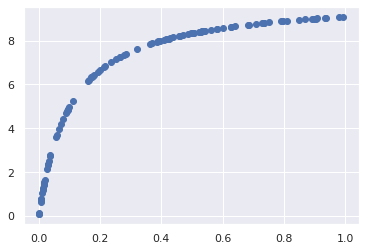

In [ ]:
X = np.random.rand(100,1) ** 2
y = 10 - 1./(X.ravel()+ 0.1 )

plt.scatter(X,y);

Un modelo lineal simple utiliza una combinación lineal de las características de entrada para predecir  una salida

$$\hat y = w_0 + w_1 x_1 + \cdots + w_n x_n$$








In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

LR = LinearRegression().fit(X_train, y_train)
LR.score(X_test, y_test)

0.7416466519617855

Una forma fácil de extender el modelo lineal es incluir combinaciones de pares de características de entrada:

$$\hat y = w_0 + w_1 x_1 + \cdots w_n x_n + w_{11}x_1 x_1 + w_{12} x_1 x_2 + \cdots$$

Esto nos permite capturar interacciones entre características y, por lo tanto, estos pares se denominan *características de interacción*. Si la transformación es de la forma $f_n(x) = x^n$ obtenemos lo que se conoce como una **regresión polinomial**. En nuestro caso, tendríamos:

$$\hat y = w_0 + w_1 x_1 + w_2 x_1^2$$

De esta manera podemos adaptar la regresión lineal a relaciones no lineales entre las variables. Observe que este sigue siendo un modelo lineal: la linealidad se refiere al hecho de que los coeficientes nunca se multiplican ni se dividen entre sí. 

Lo que hemos hecho efectivamente es tomar nuestros valores de $X$ unidimensionales y proyectarlos en una dimensión superior, de modo que un ajuste lineal pueda encajar relaciones más complicadas entre $X$ y $y$.

Podemos implementar la regresión polinomica utilizando el transformador `PolynomialFeatures` de Sklearn:

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree= 2, include_bias=False)

X_train_pol = poly.fit_transform(X_train)
X_test_pol = poly.fit_transform(X_test)

X_pol = poly.fit_transform(X)
X_pol.shape

(100, 2)

In [ ]:
X.shape

(100, 1)

In [ ]:
LR = LinearRegression().fit(X_train_pol, y_train)

LR.score(X_test_pol, y_test)

0.9375255850457651

**Ejercicio:** Escriba una función que tome como argumento el grado del polinomio por defecto grado 2 y que construya un Pipeline que encadene la transformación polinomial de las características y la construcción de un modelo de regresión lineal

In [ ]:
def PolyReg(degree = 2):
  return make_pipeline(PolynomialFeatures(degree), 
                       LinearRegression())
  
p = PolyReg().fit(X_train, y_train)

In [ ]:
p.score(X_test,y_test)

0.9375255850457651